TensorFlow version: 2.20.0
Found 210 images belonging to 3 classes.
Successfully loaded validation data. Class indices: {'dead': 0, 'healthy': 1, 'unhealthy': 2}


c:\Users\Krishitha1908\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Successfully loaded model.
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - accuracy: 0.9238 - loss: 0.2947
Validation Accuracy: 0.9238
Validation Loss: 0.2947


6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/stepWARNING:tensorflow:6 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001FF9259CE50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step

Classification Report:
              precision    recall  f1-score   support

        dead       0.91      0.91      0.91        70
     healthy       1.00      0.93      0.96        55
   unhealthy       0.89      0.93      0.91        85

    accuracy                           0.92       210
   macro avg       0.93      0.92      0.93       210
weighted avg       0.93      0.92      0.92       210



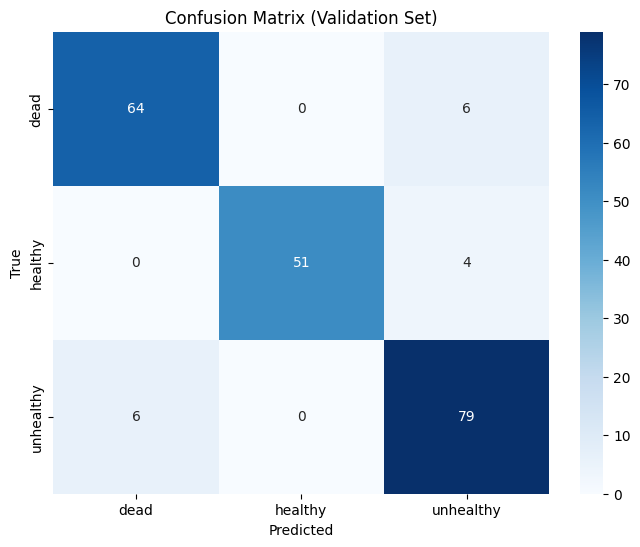

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Verify TensorFlow
try:
    print("TensorFlow version:", tf.__version__)
except ImportError:
    print("TensorFlow not found. Please ensure it is installed in the active environment.")
    exit(1)

# Define paths and parameters
base_dir = r'D:\SEM5\SIH\leaf_grok\archive\dataset'  # Adjust if dataset is directly under archive
valid_dir = os.path.join(base_dir, 'valid')  # Use 'validation' if that's the folder name
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
model_path = 'leaf_classifier_model.h5'

# Verify validation directory and model
if not os.path.exists(valid_dir):
    print(f"Error: Validation directory not found at {valid_dir}. Please check the path and ensure it contains subfolders (dead, healthy, unhealthy).")
    print("Available directories:", os.listdir(base_dir))
    exit(1)
if not os.path.exists(model_path):
    print(f"Error: Model file {model_path} not found in the current directory. Please ensure it was saved during training.")
    print("Current working directory:", os.getcwd())
    exit(1)

try:
    # Preprocessing for validation data
    valid_datagen = ImageDataGenerator(rescale=1./255)

    # Load validation data
    valid_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    print("Successfully loaded validation data. Class indices:", valid_generator.class_indices)

    # Load model
    model = tf.keras.models.load_model(model_path)
    print("Successfully loaded model.")

    # Evaluate model on validation set
    valid_loss, valid_accuracy = model.evaluate(valid_generator)
    print(f"Validation Accuracy: {valid_accuracy:.4f}")
    print(f"Validation Loss: {valid_loss:.4f}")

    # Get predictions
    valid_generator.reset()
    predictions = model.predict(valid_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = valid_generator.classes
    class_labels = list(valid_generator.class_indices.keys())

    # Classification report
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix (Validation Set)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('confusion_matrix_validation.png')
    plt.show()

except Exception as e:
    print(f"Error during evaluation: {e}")

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

# Verify TensorFlow
try:
    print("TensorFlow version:", tf.__version__)
except ImportError:
    print("TensorFlow not found. Please ensure it is installed in the active environment.")
    exit(1)

# Define parameters
IMG_HEIGHT, IMG_WIDTH = 224, 224
model_path = 'leaf_classifier_model.h5'
class_labels = ['dead', 'healthy', 'unhealthy']  # Adjust if class names differ

# Verify model file
if not os.path.exists(model_path):
    print(f"Error: Model file {model_path} not found in the current directory. Please ensure it was saved during training.")
    print("Current working directory:", os.getcwd())
    exit(1)

# Load model
try:
    model = tf.keras.models.load_model(model_path)
    print("Successfully loaded model.")
except Exception as e:
    print(f"Error loading model: {e}")
    exit(1)

# Function to predict image class
def predict_image(image_path):
    try:
        # Load and preprocess the image
        img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array /= 255.0  # Rescale to [0,1]

        # Make prediction
        prediction = model.predict(img_array)
        predicted_class = np.argmax(prediction, axis=1)[0]
        confidence = np.max(prediction) * 100  # Convert to percentage

        # Output result
        print(f"\nImage: {os.path.basename(image_path)}")
        print(f"Predicted Class: {class_labels[predicted_class]}")
        print(f"Confidence: {confidence:.2f}%")
        for i, label in enumerate(class_labels):
            print(f"{label}: {prediction[0][i] * 100:.2f}%")

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")

# Example usage: Replace with the path to your image
image_path = r'test3.jpg'  # Update with your image path
if os.path.exists(image_path):
    predict_image(image_path)
else:
    print(f"Error: Image not found at {image_path}. Please provide a valid image path.")

TensorFlow version: 2.20.0
Successfully loaded model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step

Image: test3.jpg
Predicted Class: unhealthy
Confidence: 99.95%
dead: 0.05%
healthy: 0.00%
unhealthy: 99.95%
